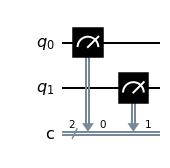

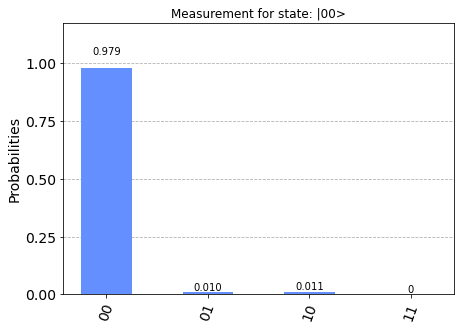

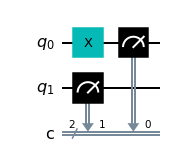

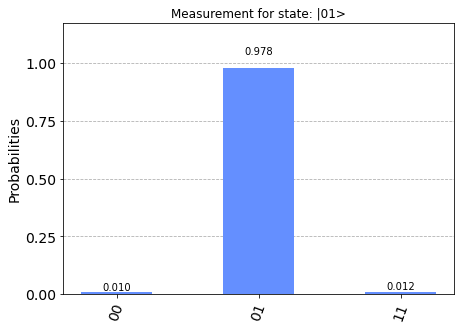

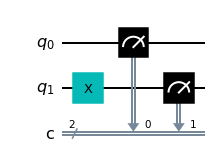

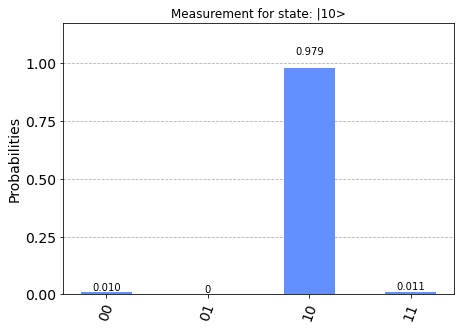

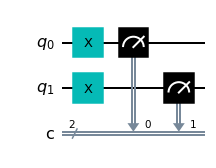

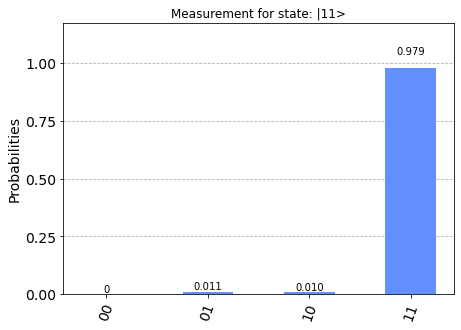


Bell circuit:


None

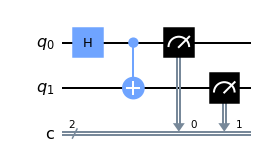

Bell measurement with noise present:


None

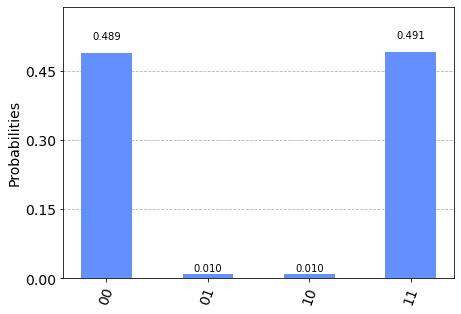


Measurement matrix M:
 [[0.9808, 0.0107, 0.0095, 0.0001], [0.0095, 0.9788, 0.0001, 0.0107], [0.0096, 0.0002, 0.9814, 0.0087], [0.0001, 0.0103, 0.009, 0.9805]]

Ideal distribution:
 [[5000], [0], [0], [5000]]

Distribution affected by noise:
 [[4904.5]
 [ 101. ]
 [  91.5]
 [4903. ]]

Inverse M matrix:
 [[ 1.01978044e+00 -1.11470783e-02 -9.87135367e-03  1.05228426e-04]
 [-9.89772783e-03  1.02188470e+00  9.39504466e-05 -1.11514471e-02]
 [-9.97422955e-03 -4.05845410e-06  1.01913199e+00 -9.04172099e-03]
 [ 9.15212840e-05 -1.07335657e-02 -9.35458279e-03  1.02008794e+00]]

Mitigated distribution:
 [[ 5.00000000e+03]
 [-7.10542736e-15]
 [ 2.84217094e-14]
 [ 5.00000000e+03]] 

Circuit mcalcal_00 :


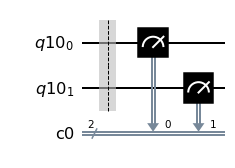

Circuit mcalcal_01 :


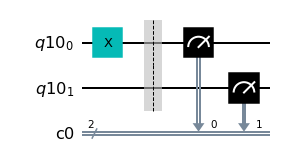

Circuit mcalcal_10 :


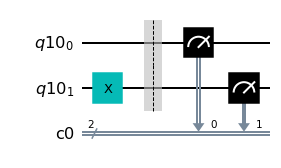

Circuit mcalcal_11 :


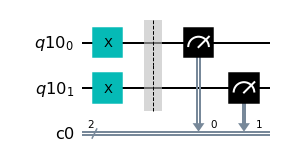

meas_fitter cal_matrix:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 

meas_fitter cal_matrix:
 [[0.8099 0.0872 0.086  0.0095]
 [0.0912 0.8116 0.0084 0.0888]
 [0.089  0.0112 0.8175 0.0881]
 [0.0099 0.09   0.0881 0.8136]] 



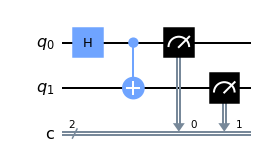

Noisy bell circuit measurement values:
 {'00': 4170, '01': 867, '10': 908, '11': 4055}

Mitigated bell circuit measurement values:
 {'00': 5073.9752739048745, '01': 1.7517669606559316e-11, '10': 20.823233929837297, '11': 4905.201492165272}


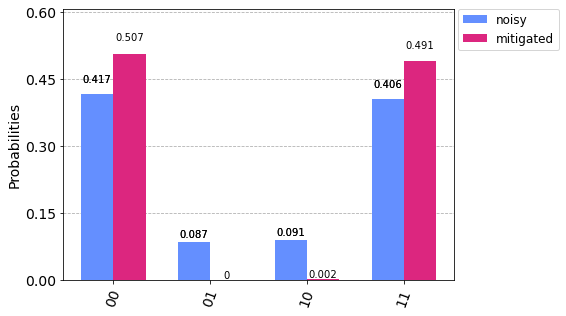


Bit Flip ECC Circuit
----------------------


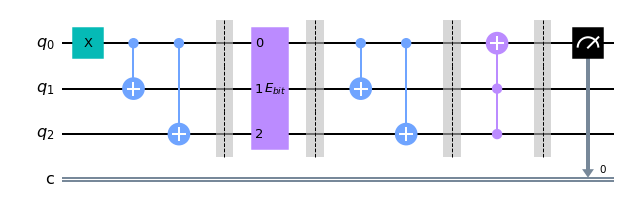

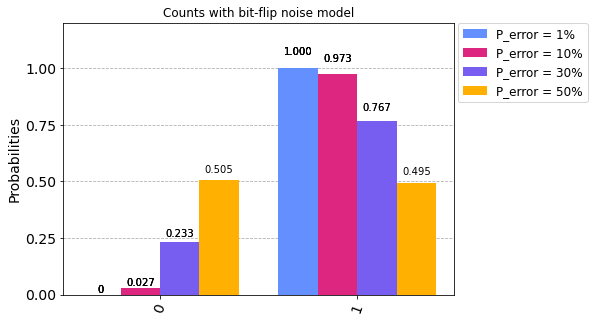


Phase Flip ECC Circuit
----------------------


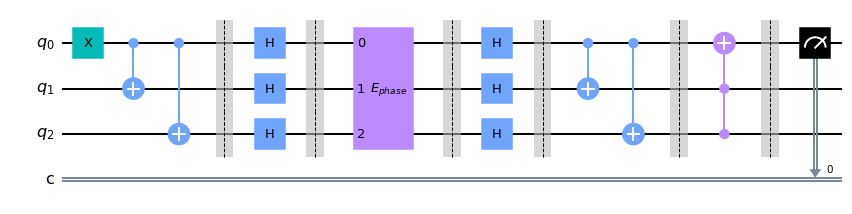

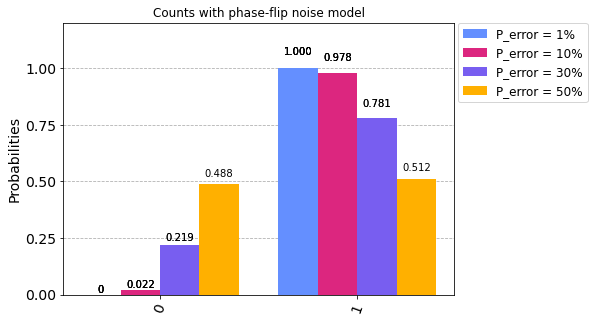


Bit Flip ECC Stabilizer Circuit
----------------------


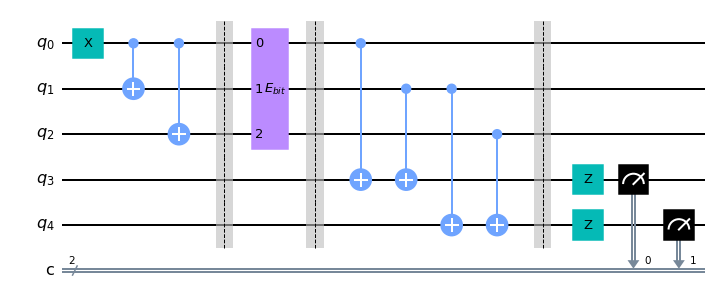

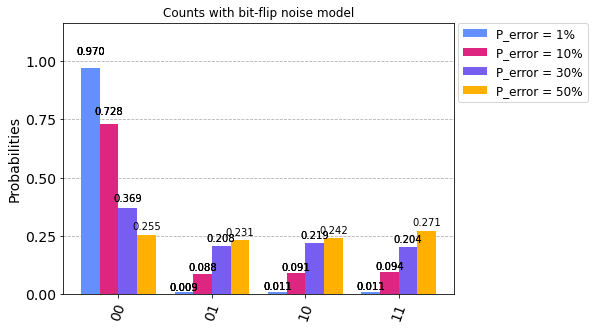


Phase Flip ECC Stabilizer Circuit
----------------------


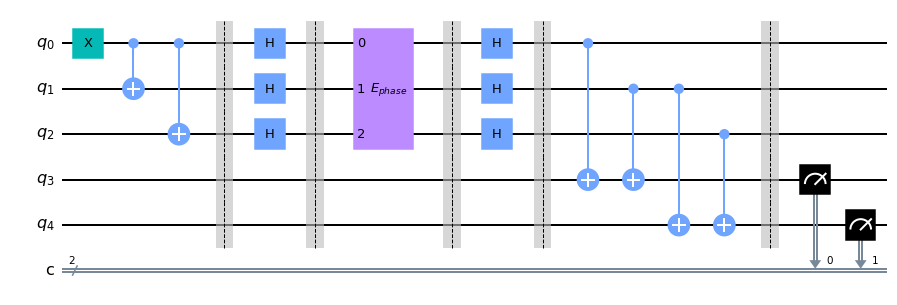

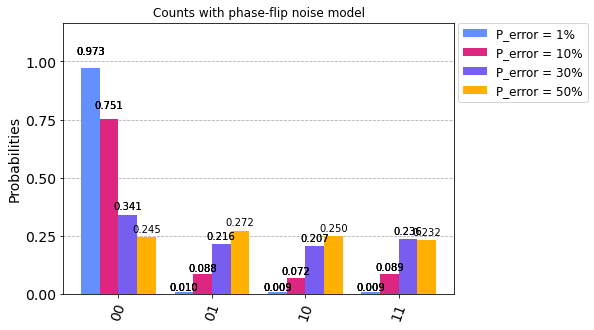


5 qubit perfect ECC Circuit
----------------------


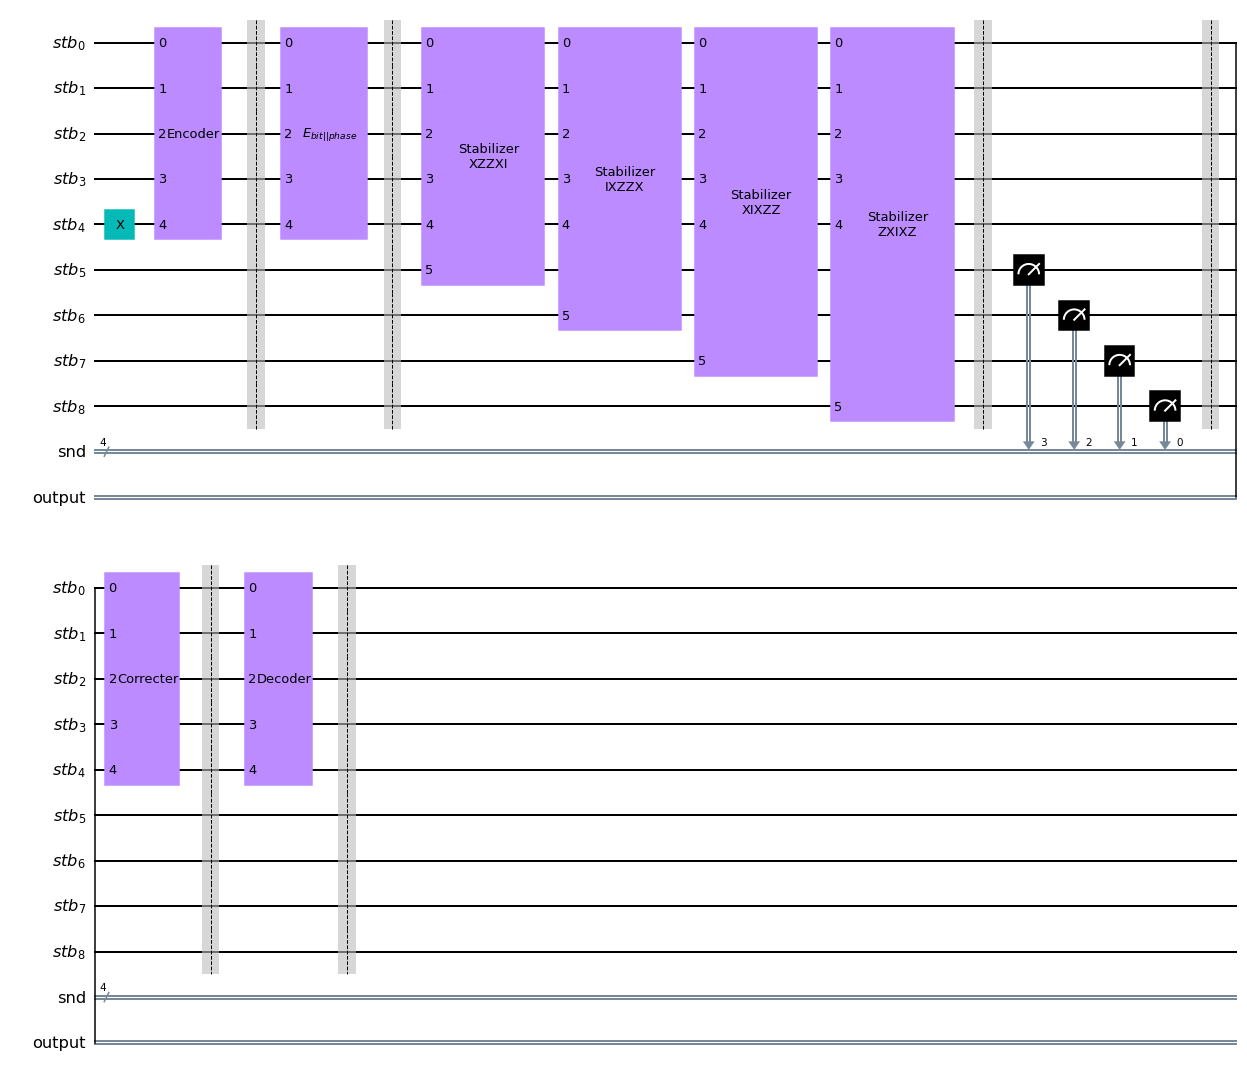

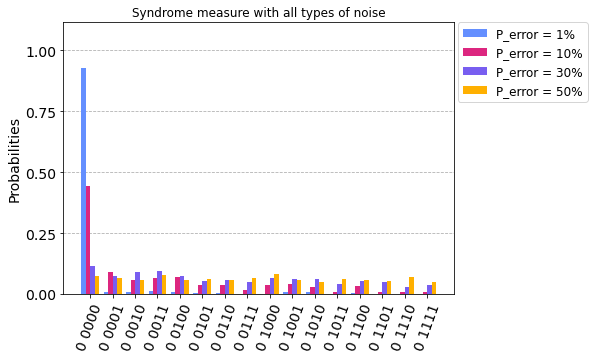

In [1]:
##############################################
################## IMPORTS ###################
##############################################

from qiskit import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

import numpy as np
import scipy.linalg as la

aer_sim = Aer.get_backend('qasm_simulator')

##############################################
##############################################
################# Measurement ################
##############################################
##############################################

# Create a noise simulation
def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])               # with given chance p an X error is made

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")  # measurement error is applied to measurements
        
    return noise_model

noise_model = get_noise(0.01)                                       # make X error chance 1%

# Test measurement noise simulation on simple circuit
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0]=='1':
        qc.x(1)
    if state[1]=='1':
        qc.x(0)  
    qc.measure([0, 1], [0, 1])
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc)
    counts = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result().get_counts()
    display(qc.draw(output = 'mpl'))
    display(plot_histogram(counts, title = 'Measurement for state: |'+ state+ '>'))

# Test measurement noise simulation on Bell circuit
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure([0, 1], [0, 1])
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
counts = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result().get_counts()

display(print('\nBell circuit:'))
display(qc.draw(output = 'mpl'))
display(print('Bell measurement with noise present:'))
display(plot_histogram(counts))

# Matrix with measurement values from above circuits
M = [[0.9808,0.0107,0.0095,0.0001],
    [0.0095,0.9788,0.0001,0.0107],
    [0.0096,0.0002,0.9814,0.0087],
    [0.0001,0.0103,0.0090,0.9805]]
print('\nMeasurement matrix M:\n', M)

# Ideal value distribution of bell state β_00 for 10k shots (5k x '00' & 5k x '11')
Cideal = [[5000],
          [0],
          [0],
          [5000]]
print('\nIdeal distribution:\n', Cideal)

# Dot product of M with C_ideal gives us distribution affected by noise
Cnoisy = np.dot(M, Cideal)
print('\nDistribution affected by noise:\n', Cnoisy)

# Calculating inverse M
Minv = la.inv(M)
print('\nInverse M matrix:\n', Minv)

# Mitigated distribution C
Cmitigated = np.dot(Minv, Cnoisy)
print('\nMitigated distribution:\n', Cmitigated, '\n')

# Calibrating circuits
meas_calibs, state_labels = complete_meas_cal(qr=QuantumRegister(2), circlabel='mcal')

for circuit in meas_calibs:
    print('Circuit',circuit.name, ':')
    display(circuit.draw(output = 'mpl'))
    
# Execute the calibration circuits without noise
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print('meas_fitter cal_matrix:\n',meas_fitter.cal_matrix, '\n')

noise_model = get_noise(0.1)

# Execute the calibration circuits with noise
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print('meas_fitter cal_matrix:\n', meas_fitter.cal_matrix, '\n')

# Create bell circuit
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure([0, 1], [0, 1])

# Execute bell circuit with noise
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=10000)
results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()
noisy_counts = results.get_counts()
display(qc.draw(output = 'mpl'))
print('Noisy bell circuit measurement values:\n', noisy_counts)

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()
print('\nMitigated bell circuit measurement values:\n', mitigated_counts)

noisy_counts = results.get_counts()
display(plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated']))

##############################################
##############################################
############ 3 qubit bit flip ECC ############
##############################################
##############################################

print('\nBit Flip ECC Circuit\n----------------------')

    # Create noise model for bit flip channel
def get_noise(p):

    # With given chance p an X error is made
    channel_error = pauli_error([('X',p), ('I', 1 - p)])

    # Add errors to noise model
    noise_bit_flip = NoiseModel()
    noise_bit_flip.add_all_qubit_quantum_error(channel_error, ["id"])

    return noise_bit_flip

noise_bit_flip1 = get_noise(0.01)
noise_bit_flip10 = get_noise(0.1)
noise_bit_flip30 = get_noise(0.3)
noise_bit_flip50 = get_noise(0.5)

qr_bitflip = QuantumRegister(3,'q')
cr_bitflip = ClassicalRegister(1,'c')
bitflip_ecc = QuantumCircuit(qr_bitflip,cr_bitflip)

bitflip_ecc.x(0)

# Encode logical qubit to ancilla qubits
bitflip_ecc.cx(qr_bitflip[0],qr_bitflip[1])
bitflip_ecc.cx(qr_bitflip[0],qr_bitflip[2])
bitflip_ecc.barrier()

# Create the bit flip channel
bitflip_channel = QuantumCircuit(3, name = "$E_{bit}$")
bitflip_channel.id(0)
bitflip_channel.id(1)
bitflip_channel.id(2)
custom_gate = bitflip_channel.to_instruction()

# Append channel to circuit
bitflip_ecc.append(custom_gate, [0,1,2])
bitflip_ecc.barrier()

# Error dissipation 
bitflip_ecc.cx(qr_bitflip[0], qr_bitflip[1])
bitflip_ecc.cx(qr_bitflip[0], qr_bitflip[2])
bitflip_ecc.barrier()

# Error correction
bitflip_ecc.ccx(qr_bitflip[2],
                qr_bitflip[1],
                qr_bitflip[0])
bitflip_ecc.barrier()

# Measurement is made
bitflip_ecc.measure(qr_bitflip[0], cr_bitflip[0])
#bitflip_ecc.measure(qr_bitflip[1], cr_bitflip[1])
#bitflip_ecc.measure(qr_bitflip[2], cr_bitflip[2])

display(bitflip_ecc.draw(output = 'mpl'))

# Get the basis gates for the noise model
basis_gates = noise_bit_flip1.basis_gates

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute noisy simulation and get counts
result_noise = execute(bitflip_ecc, simulator,
                       noise_model=noise_bit_flip1,
                       basis_gates=basis_gates).result()
counts_noise1 = result_noise.get_counts(bitflip_ecc)

result_noise = execute(bitflip_ecc, simulator,
                       noise_model=noise_bit_flip10,
                       basis_gates=basis_gates).result()
counts_noise10 = result_noise.get_counts(bitflip_ecc)

result_noise = execute(bitflip_ecc, simulator,
                       noise_model=noise_bit_flip30,
                       basis_gates=basis_gates).result()
counts_noise30 = result_noise.get_counts(bitflip_ecc)

result_noise = execute(bitflip_ecc, simulator,
                       noise_model=noise_bit_flip50,
                       basis_gates=basis_gates).result()
counts_noise50 = result_noise.get_counts(bitflip_ecc)

display(plot_histogram([counts_noise1, counts_noise10, counts_noise30, counts_noise50], 
                       title="Counts with bit-flip noise model",
                       legend=['P_error = 1%', 'P_error = 10%', 'P_error = 30%', 'P_error = 50%']))

##############################################
##############################################
########### 3 qubit phase flip ECC ###########
##############################################
##############################################

print('\nPhase Flip ECC Circuit\n----------------------')

# Create noise model for bit flip channel
def get_noise(p):

    # With given chance p an X error is made
    channel_error = pauli_error([('Z',p), ('I', 1 - p)])

    # Add errors to noise model
    noise_phase_flip = NoiseModel()
    noise_phase_flip.add_all_qubit_quantum_error(channel_error, ["id"])

    return noise_phase_flip

noise_phase_flip1 = get_noise(0.01)
noise_phase_flip10 = get_noise(0.1)
noise_phase_flip30 = get_noise(0.3)
noise_phase_flip50 = get_noise(0.5)

qr_phaseflip = QuantumRegister(3,'q')
cr_phaseflip = ClassicalRegister(1,'c')
phaseflip_ecc = QuantumCircuit(qr_phaseflip,cr_phaseflip)

phaseflip_ecc.x(0)

# Encode logical qubit to ancilla qubits
phaseflip_ecc.cx(qr_phaseflip[0],qr_phaseflip[1])
phaseflip_ecc.cx(qr_phaseflip[0],qr_phaseflip[2])
phaseflip_ecc.barrier()

# Superpose qubits
phaseflip_ecc.h(qr_phaseflip[0])
phaseflip_ecc.h(qr_phaseflip[1])
phaseflip_ecc.h(qr_phaseflip[2])
phaseflip_ecc.barrier()

# Create the bit flip channel
phaseflip_channel = QuantumCircuit(3, name = "$E_{phase}$")
phaseflip_channel.id(0)
phaseflip_channel.id(1)
phaseflip_channel.id(2)
custom_gate = phaseflip_channel.to_instruction()

# Append channel to circuit
phaseflip_ecc.append(custom_gate, [0,1,2])
phaseflip_ecc.barrier()

# Depose qubits
phaseflip_ecc.h(qr_phaseflip[0])
phaseflip_ecc.h(qr_phaseflip[1])
phaseflip_ecc.h(qr_phaseflip[2])
phaseflip_ecc.barrier()

# Error dissipation 
phaseflip_ecc.cx(qr_phaseflip[0],qr_phaseflip[1])
phaseflip_ecc.cx(qr_phaseflip[0],qr_phaseflip[2])
phaseflip_ecc.barrier()

# Error correction
phaseflip_ecc.ccx(qr_phaseflip[2], 
                  qr_phaseflip[1], 
                  qr_phaseflip[0])
phaseflip_ecc.barrier()

# Measurement is made
phaseflip_ecc.measure(qr_phaseflip[0], cr_phaseflip[0])
#phaseflip_ecc.measure(qr_phaseflip[1], cr_phaseflip[1])
#phaseflip_ecc.measure(qr_phaseflip[2], cr_phaseflip[2])

display(phaseflip_ecc.draw(output = 'mpl'))

# Get the basis gates for the noise model
basis_gates = noise_phase_flip1.basis_gates

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute noisy simulation and get counts
result_noise = execute(phaseflip_ecc, simulator,
                       noise_model=noise_phase_flip1,
                       basis_gates=basis_gates).result()
counts_noise1 = result_noise.get_counts(phaseflip_ecc)

result_noise = execute(phaseflip_ecc, simulator,
                       noise_model=noise_phase_flip10,
                       basis_gates=basis_gates).result()
counts_noise10 = result_noise.get_counts(phaseflip_ecc)

result_noise = execute(phaseflip_ecc, simulator,
                       noise_model=noise_phase_flip30,
                       basis_gates=basis_gates).result()
counts_noise30 = result_noise.get_counts(phaseflip_ecc)

result_noise = execute(phaseflip_ecc, simulator,
                       noise_model=noise_phase_flip50,
                       basis_gates=basis_gates).result()
counts_noise50 = result_noise.get_counts(phaseflip_ecc)

display(plot_histogram([counts_noise1, counts_noise10, counts_noise30, counts_noise50], 
                       title="Counts with phase-flip noise model", 
                       legend=['P_error = 1%', 'P_error = 10%', 'P_error = 30%', 'P_error = 50%']))

#########################################################
#########################################################
############ 3 qubit bit flip stabilizer ECC ############
#########################################################
#########################################################

print('\nBit Flip ECC Stabilizer Circuit\n----------------------')

    # Create noise model for bit flip channel
def get_noise(p):

    # With given chance p an X error is made
    channel_error = pauli_error([('X',p), ('I', 1 - p)])

    # Add errors to noise model
    noise_bit_flip = NoiseModel()
    noise_bit_flip.add_all_qubit_quantum_error(channel_error, ["id"])

    return noise_bit_flip

noise_bit_flip1 = get_noise(0.01)
noise_bit_flip10 = get_noise(0.1)
noise_bit_flip30 = get_noise(0.3)
noise_bit_flip50 = get_noise(0.5)

qr_bitflip = QuantumRegister(5,'q')
cr_bitflip = ClassicalRegister(2,'c')
bitflip_ecc = QuantumCircuit(qr_bitflip,cr_bitflip)

bitflip_ecc.x(0)

# Encode logical qubit to ancilla qubits
bitflip_ecc.cx(qr_bitflip[0],qr_bitflip[1])
bitflip_ecc.cx(qr_bitflip[0],qr_bitflip[2])
bitflip_ecc.barrier()

# Create the bit flip channel
bitflip_channel = QuantumCircuit(3, name = "$E_{bit}$")
bitflip_channel.id(0)
bitflip_channel.id(1)
bitflip_channel.id(2)
custom_gate = bitflip_channel.to_instruction()

# Append channel to circuit
bitflip_ecc.append(custom_gate, [0,1,2])
#bitflip_ecc.x(1)
bitflip_ecc.barrier()

bitflip_ecc.cx(qr_bitflip[0], qr_bitflip[3])
bitflip_ecc.cx(qr_bitflip[1], qr_bitflip[3])

bitflip_ecc.cx(qr_bitflip[1], qr_bitflip[4])
bitflip_ecc.cx(qr_bitflip[2], qr_bitflip[4])

bitflip_ecc.barrier()
bitflip_ecc.z(3)
bitflip_ecc.z(4)

# Measurement is made
bitflip_ecc.measure(qr_bitflip[3], cr_bitflip[0])
bitflip_ecc.measure(qr_bitflip[4], cr_bitflip[1])

display(bitflip_ecc.draw(output = 'mpl'))

# Get the basis gates for the noise model
basis_gates = noise_bit_flip1.basis_gates

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute noisy simulation and get counts
result_noise = execute(bitflip_ecc, simulator,
                       noise_model=noise_bit_flip1,
                       basis_gates=basis_gates).result()
counts_noise1 = result_noise.get_counts(bitflip_ecc)

result_noise = execute(bitflip_ecc, simulator,
                       noise_model=noise_bit_flip10,
                       basis_gates=basis_gates).result()
counts_noise10 = result_noise.get_counts(bitflip_ecc)

result_noise = execute(bitflip_ecc, simulator,
                       noise_model=noise_bit_flip30,
                       basis_gates=basis_gates).result()
counts_noise30 = result_noise.get_counts(bitflip_ecc)

result_noise = execute(bitflip_ecc, simulator,
                       noise_model=noise_bit_flip50,
                       basis_gates=basis_gates).result()
counts_noise50 = result_noise.get_counts(bitflip_ecc)

display(plot_histogram([counts_noise1, counts_noise10, counts_noise30, counts_noise50], 
                       title="Counts with bit-flip noise model",
                       legend=['P_error = 1%', 'P_error = 10%', 'P_error = 30%', 'P_error = 50%']))

#########################################################
#########################################################
########### 3 qubit phase flip stabilizer ECC ###########
#########################################################
#########################################################

print('\nPhase Flip ECC Stabilizer Circuit\n----------------------')

# Create noise model for bit flip channel
def get_noise(p):

    # With given chance p an X error is made
    channel_error = pauli_error([('Z',p), ('I', 1 - p)])

    # Add errors to noise model
    noise_phase_flip = NoiseModel()
    noise_phase_flip.add_all_qubit_quantum_error(channel_error, ["id"])

    return noise_phase_flip

noise_phase_flip1 = get_noise(0.01)
noise_phase_flip10 = get_noise(0.1)
noise_phase_flip30 = get_noise(0.3)
noise_phase_flip50 = get_noise(0.5)

qr_phaseflip = QuantumRegister(5,'q')
cr_phaseflip = ClassicalRegister(2,'c')
phaseflip_ecc = QuantumCircuit(qr_phaseflip,cr_phaseflip)

phaseflip_ecc.x(0)

# Encode logical qubit to ancilla qubits
phaseflip_ecc.cx(qr_phaseflip[0],qr_phaseflip[1])
phaseflip_ecc.cx(qr_phaseflip[0],qr_phaseflip[2])
phaseflip_ecc.barrier()

# Superpose qubits
phaseflip_ecc.h(qr_phaseflip[0])
phaseflip_ecc.h(qr_phaseflip[1])
phaseflip_ecc.h(qr_phaseflip[2])
phaseflip_ecc.barrier()

# Create the bit flip channel
phaseflip_channel = QuantumCircuit(3, name = "$E_{phase}$")
phaseflip_channel.id(0)
phaseflip_channel.id(1)
phaseflip_channel.id(2)
custom_gate = phaseflip_channel.to_instruction()

# Append channel to circuit
phaseflip_ecc.append(custom_gate, [0,1,2])
#phaseflip_ecc.z(2)
phaseflip_ecc.barrier()
phaseflip_ecc.h(qr_phaseflip[0])
phaseflip_ecc.h(qr_phaseflip[1])
phaseflip_ecc.h(qr_phaseflip[2])
phaseflip_ecc.barrier()

phaseflip_ecc.cx(qr_phaseflip[0], qr_phaseflip[3])
phaseflip_ecc.cx(qr_phaseflip[1], qr_phaseflip[3])

phaseflip_ecc.cx(qr_phaseflip[1], qr_phaseflip[4])
phaseflip_ecc.cx(qr_phaseflip[2], qr_phaseflip[4])
phaseflip_ecc.barrier()

# Measurement is made
phaseflip_ecc.measure(qr_phaseflip[3], cr_phaseflip[0])
phaseflip_ecc.measure(qr_phaseflip[4], cr_phaseflip[1])

display(phaseflip_ecc.draw(output = 'mpl'))

# Get the basis gates for the noise model
basis_gates = noise_phase_flip1.basis_gates

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute noisy simulation and get counts
result_noise = execute(phaseflip_ecc, simulator,
                       noise_model=noise_phase_flip1,
                       basis_gates=basis_gates).result()
counts_noise1 = result_noise.get_counts(phaseflip_ecc)

result_noise = execute(phaseflip_ecc, simulator,
                       noise_model=noise_phase_flip10,
                       basis_gates=basis_gates).result()
counts_noise10 = result_noise.get_counts(phaseflip_ecc)

result_noise = execute(phaseflip_ecc, simulator,
                       noise_model=noise_phase_flip30,
                       basis_gates=basis_gates).result()
counts_noise30 = result_noise.get_counts(phaseflip_ecc)

result_noise = execute(phaseflip_ecc, simulator,
                       noise_model=noise_phase_flip50,
                       basis_gates=basis_gates).result()
counts_noise50 = result_noise.get_counts(phaseflip_ecc)

display(plot_histogram([counts_noise1, counts_noise10, counts_noise30, counts_noise50], 
                       title="Counts with phase-flip noise model", 
                       legend=['P_error = 1%', 'P_error = 10%', 'P_error = 30%', 'P_error = 50%']))

##############################################
##############################################
############# 5 qubit perfect ECC ############
##############################################
##############################################

print('\n5 qubit perfect ECC Circuit\n----------------------')

# Create noise model for bit flip channel
def get_noise(p):

    # With given chance p an X error is made
    all_error = pauli_error([('X', p/2), ('Z', p/2), ('I', 1 - p)])

    # Add errors to noise model
    all_noise = NoiseModel()
    all_noise.add_all_qubit_quantum_error(all_error, ["id"])

    return all_noise

all_noise = get_noise(0)
all_noise1 = get_noise(0.01)
all_noise10 = get_noise(0.1)
all_noise30 = get_noise(0.3)
all_noise50 = get_noise(0.5)

qr_perfect = QuantumRegister(9,'stb')
cr_perfect = ClassicalRegister(4,'snd')
debug = ClassicalRegister(5,'debug')
output = ClassicalRegister(1,'output')
#perfect_ecc = QuantumCircuit(qr_perfect,debug)
perfect_ecc = QuantumCircuit(qr_perfect,cr_perfect,output)

# Create the encoding circuit
perfect_encoder = QuantumCircuit(5, name = "Encoder")
perfect_encoder.h(0)
perfect_encoder.h(1)
perfect_encoder.h(2)
perfect_encoder.h(3)
perfect_encoder.z(4)
perfect_encoder.barrier()

perfect_encoder.cx(0,4)
perfect_encoder.cx(1,4)
perfect_encoder.cx(2,4)
perfect_encoder.cx(3,4)

perfect_encoder.cz(0,4)
perfect_encoder.cz(0,1)
perfect_encoder.cz(1,2)
perfect_encoder.cz(2,3)
perfect_encoder.cz(3,4)

custom_encoder = perfect_encoder.to_instruction()

# Create the bit & phase flip channel
bitphase_channel = QuantumCircuit(5, name = "$E_{bit||phase}$")
bitphase_channel.id(0)
bitphase_channel.id(1)
bitphase_channel.id(2)
bitphase_channel.id(3)
bitphase_channel.id(4)
custom_channel = bitphase_channel.to_instruction()

# Create the stabilizer generator for XZZXI
perfect_XZZXI = QuantumCircuit(6, name = "Stabilizer\nXZZXI")
perfect_XZZXI.h(5)
perfect_XZZXI.cx(5,0)
perfect_XZZXI.cz(5,1)
perfect_XZZXI.cz(5,2)
perfect_XZZXI.cx(5,3)
perfect_XZZXI.id(4)
perfect_XZZXI.h(5)
custom_XZZXI = perfect_XZZXI.to_instruction()

# Create the stabilizer generator for IXZZX
perfect_IXZZX = QuantumCircuit(6, name = "Stabilizer\nIXZZX")
perfect_IXZZX.h(5)
perfect_IXZZX.id(0)
perfect_IXZZX.cx(5,1)
perfect_IXZZX.cz(5,2)
perfect_IXZZX.cz(5,3)
perfect_IXZZX.cx(5,4)
perfect_IXZZX.h(5)
custom_IXZZX = perfect_IXZZX.to_instruction()

# Create the stabilizer generator for XIXZZ
perfect_XIXZZ = QuantumCircuit(6, name = "Stabilizer\nXIXZZ")
perfect_XIXZZ.h(5)
perfect_XIXZZ.cx(5,0)
perfect_XIXZZ.id(1)
perfect_XIXZZ.cx(5,2)
perfect_XIXZZ.cz(5,3)
perfect_XIXZZ.cz(5,4)
perfect_XIXZZ.h(5)
custom_XIXZZ = perfect_XIXZZ.to_instruction()

# Create the stabilizer generator for ZXIXZ
perfect_ZXIXZ = QuantumCircuit(6, name = "Stabilizer\nZXIXZ")
perfect_ZXIXZ.h(5)
perfect_ZXIXZ.cz(5,0)
perfect_ZXIXZ.cx(5,1)
perfect_ZXIXZ.id(2)
perfect_ZXIXZ.cx(5,3)
perfect_ZXIXZ.cz(5,4)
perfect_ZXIXZ.h(5)
custom_ZXIXZ = perfect_ZXIXZ.to_instruction()

# Create the correcting circuit
perfect_correcter = QuantumCircuit(5, name = "Correcter")
#perfect_correcter.x(0)
#perfect_correcter.x(1)
#perfect_correcter.x(2)
#perfect_correcter.x(3)
#perfect_correcter.x(4)

custom_correcter = perfect_correcter.to_instruction()

# Create the decoding circuit
perfect_decoder = QuantumCircuit(5, name = "Decoder")
perfect_decoder.cz(3,4)
perfect_decoder.cz(2,3)
perfect_decoder.cz(1,2)
perfect_decoder.cz(0,1)
perfect_decoder.cz(0,4)

perfect_decoder.cx(3,4)
perfect_decoder.cx(2,4)
perfect_decoder.cx(1,4)
perfect_decoder.cx(0,4)
perfect_decoder.barrier()

perfect_decoder.h(0)
perfect_decoder.h(1)
perfect_decoder.h(2)
perfect_decoder.h(3)
perfect_decoder.z(4)
perfect_decoder.barrier()

custom_decoder = perfect_decoder.to_instruction()

# Append custom gates to circuit
perfect_ecc.x(4)
perfect_ecc.append(custom_encoder, [0,1,2,3,4])
perfect_ecc.barrier()

# Measure encoded state
#perfect_ecc.measure(qr_perfect[0], debug[0])
#perfect_ecc.measure(qr_perfect[1], debug[1])
#perfect_ecc.measure(qr_perfect[2], debug[2])
#perfect_ecc.measure(qr_perfect[3], debug[3])

perfect_ecc.append(custom_channel, [0,1,2,3,4])
#perfect_ecc.x(0)
#perfect_ecc.y(4)
#perfect_ecc.x(2)
#perfect_ecc.x(3)
#perfect_ecc.x(4)
perfect_ecc.barrier()
perfect_ecc.append(custom_XZZXI, [0,1,2,3,4,5])
perfect_ecc.append(custom_IXZZX, [0,1,2,3,4,6])
perfect_ecc.append(custom_XIXZZ, [0,1,2,3,4,7])
perfect_ecc.append(custom_ZXIXZ, [0,1,2,3,4,8])
perfect_ecc.barrier()

# Measure syndromes
perfect_ecc.measure(qr_perfect[5], cr_perfect[3])
perfect_ecc.measure(qr_perfect[6], cr_perfect[2])
perfect_ecc.measure(qr_perfect[7], cr_perfect[1])
perfect_ecc.measure(qr_perfect[8], cr_perfect[0])
perfect_ecc.barrier()

perfect_ecc.append(custom_correcter, [0,1,2,3,4])

perfect_ecc.barrier()

perfect_ecc.append(custom_decoder, [0,1,2,3,4])
perfect_ecc.barrier()

#perfect_ecc.measure(qr_perfect[4], output[0])

display(perfect_ecc.draw(output = 'mpl'))

# Get the basis gates for the noise model
basis_gates = all_noise.basis_gates

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute noisy simulation and get counts
result_noise = execute(perfect_ecc, simulator,
                       noise_model=all_noise,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(perfect_ecc)

result_noise = execute(perfect_ecc, simulator,
                       noise_model=all_noise1,
                       basis_gates=basis_gates).result()
counts_noise1 = result_noise.get_counts(perfect_ecc)

result_noise = execute(perfect_ecc, simulator,
                       noise_model=all_noise10,
                       basis_gates=basis_gates).result()
counts_noise10 = result_noise.get_counts(perfect_ecc)

result_noise = execute(perfect_ecc, simulator,
                       noise_model=all_noise30,
                       basis_gates=basis_gates).result()
counts_noise30 = result_noise.get_counts(perfect_ecc)

result_noise = execute(perfect_ecc, simulator,
                       noise_model=all_noise50,
                       basis_gates=basis_gates).result()
counts_noise50 = result_noise.get_counts(perfect_ecc)

display(plot_histogram([counts_noise1, counts_noise10, counts_noise30, counts_noise50], 
                       title="Syndrome measure with all types of noise",
                       legend=['P_error = 1%', 'P_error = 10%', 'P_error = 30%', 'P_error = 50%'], 
                       bar_labels = False))

#display(plot_histogram(counts_noise1, title="Encoded state measurement"))